### 1 - Data Set and Programming Problem Overview

1. Load the problem from disk into memory with load_problem.

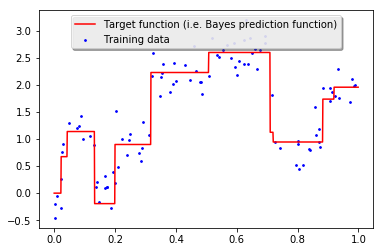

In [1]:
"""
Generating target function, featurizer, and train/validation/test splits for the Lasso homework.

Author: David S. Rosenberg <david.davidr@gmail.com>
License: Creative Commons Attribution 4.0 International License
"""

from sklearn.model_selection import train_test_split
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle


def step_fn_generator(stepLoc=0):
    def f(x):
        ret = np.zeros(len(x))
        ret[x >= stepLoc] = 1
        return ret
    return f

def linear_comb_generator(fns, coefs):
    def f(x):
        return sum(fns[i](x) * coefs[i] for i in range(len(fns)))
    return f

def get_target_and_featurizer(num_basis_fns = 100, num_nonzero = 10, coefs_true=None):
    # We'll create a basis of step functions on the interval [0,1]. We'll then
    # construct a linear combination of these step functions to be our target
    # function. We'll construct a function to "featurize" an input in [0,1]
    # into the evaluations of all functions in the basis on the input.
    # Optionally: If coefs_true is provided, they will be used to generate
    # target_fn and featurize.
    # Construct basis, to be used for generating target function

    if coefs_true is not None:
        num_basis_fns = len(coefs_true)
    else:
        nonzero_indices = np.random.choice(num_basis_fns, num_nonzero)
        coefs_true = np.zeros(num_basis_fns)
        coefs_true[nonzero_indices] = np.random.randn(num_nonzero)

    all_basis_fns = [step_fn_generator(stepLoc=s)
                     for s in np.linspace(0, 1, num_basis_fns, endpoint=False)]

    # Construct target function (the Bayes prediction function)
    target_fn = linear_comb_generator(all_basis_fns, coefs_true)

    def featurize(x):
        n = len(x)
        # Featurize input values in [0,1]
        X_ftrs = np.empty((n, num_basis_fns))
        for ftr_num in range(num_basis_fns):
            X_ftrs[:, ftr_num] = all_basis_fns[ftr_num](x)
        return X_ftrs

    return target_fn, coefs_true, featurize

def generate_data(target_fn, n=1000, noise_scale=.25, tdof=6):
    # Construct dataset
    x = np.sort(np.random.rand(n)) #chooses uniformly from [0,1)
    y_target = target_fn(x)
    y = y_target + noise_scale * np.random.standard_t(tdof,n)
    return x, y

def get_data_splits(x, y, test_frac=.2):
    ## Based on https://github.com/ageron/handson-ml/blob/master/02_end_to_end_machine_learning_project.ipynb
    n = len(y)
    shuffled_indices = np.random.permutation(n)
    n_test = int(n * test_frac)
    n_train = n - n_test
    indices_test = shuffled_indices[:n_test]
    indices_train = shuffled_indices[n_test:]
    y_train = y[indices_train]
    x_train = x[indices_train]
    y_test = y[indices_test]
    x_test = x[indices_test]
    return x_train, y_train, x_test, y_test

def generate_problem(n=200, num_basis_fns=400, num_nonzero=10, noise_scale=.25, tdof=6, test_frac=.2, write_problem=False, file_name="lasso_data.pickle"):
    target_fn, coefs_true, featurize = get_target_and_featurizer(num_basis_fns, num_nonzero)
    x, y = generate_data(target_fn, n, noise_scale, tdof)
    x_train, y_train, x_test, y_test = get_data_splits(x, y, test_frac)

    if write_problem:
        print ("Saving problem to disk.")
        data = {"coefs_true":coefs_true, "x_train":x_train,
                "y_train":np.copy(y_train), "x_test":x_test, "y_test":y_test}
        with open(file_name, 'wb') as outfile:
            pickle.dump(data, outfile, protocol=2)

    return x_train, y_train, x_test, y_test, target_fn, coefs_true, featurize

def reconstitute_problem(coefs_true, x_train, y_train, x_test, y_test):
    target_fn, coefs_true, featurize = get_target_and_featurizer(coefs_true=coefs_true)
    return x_train, y_train, x_test, y_test, target_fn, coefs_true, featurize

def load_problem(file_name):
    f_myfile = open(file_name, 'rb')
    data = pickle.load(f_myfile)
    f_myfile.close()
    return reconstitute_problem(data["coefs_true"], data["x_train"], data["y_train"],
                                data["x_test"], data["y_test"])

def main():
    lasso_data_fname = "lasso_data.pickle"
    LOAD_PROBLEM=False
    GENERATE_PROBLEM=True
    WRITE_PROBLEM=False
    if GENERATE_PROBLEM:
        n=1000
        test_frac=.9
        num_basis_fns=400
        num_nonzero=10
        noise_scale=.25 # scale factor on noise
        tdof = 6 # degrees of freedom of t-distribution generating noise
        x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = generate_problem(n=n, num_basis_fns=num_basis_fns, num_nonzero=num_nonzero, noise_scale=noise_scale, test_frac=test_frac, write_problem=WRITE_PROBLEM, file_name=lasso_data_fname)

    if LOAD_PROBLEM:
        x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(lasso_data_fname)

    # Let's plot the target function (i.e. the Bayes prediction function) as
    # well as the noisy observations from the training data, as a function of
    # the original input space, which is the interval [0,1).
#     plt.figure(figsize=(20,10))
    fig, ax = plt.subplots()
    plt.scatter(x_train, y_train, s=3, color='b', label='Training data')
    x = np.arange(0,1,.001)
    ax.plot(x, target_fn(x), 'r', label='Target function (i.e. Bayes prediction function)')
    legend = ax.legend(loc='upper center', shadow=True)
    plt.show(block=False)

if __name__ == '__main__':
    main()

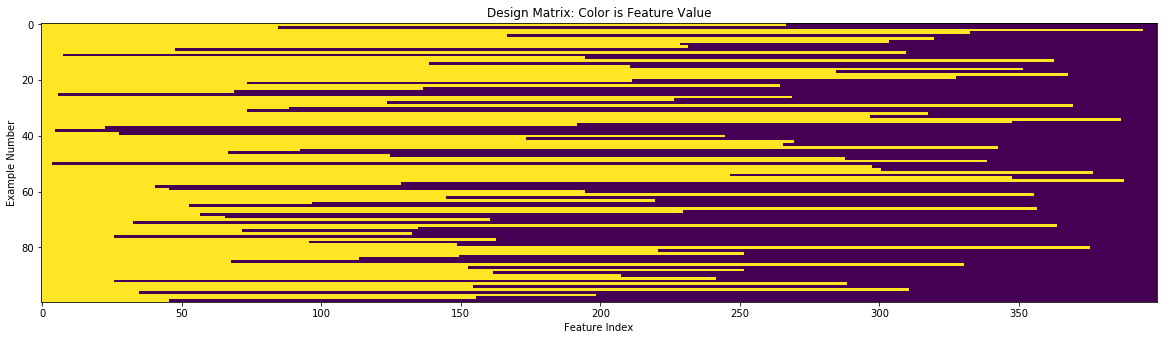

Hoping this is very close to 0:4.688428298086388e-11
    param_l2reg  mean_test_score  mean_train_score
0      0.000001         0.172579          0.006752
1      0.000003         0.172551          0.006752
2      0.000010         0.172464          0.006752
3      0.000032         0.172190          0.006754
4      0.000100         0.171345          0.006774
5      0.000316         0.168880          0.006951
6      0.001000         0.162705          0.008285
7      0.003162         0.151900          0.014953
8      0.010000         0.141887          0.032767
9      0.031623         0.139648          0.060554
10     0.100000         0.144566          0.094953
11     0.316228         0.152607          0.137121
12     1.000000         0.171068          0.197694
13     1.300000         0.179521          0.216591
14     1.600000         0.187993          0.233450
15     1.900000         0.196361          0.248803
16     2.200000         0.204553          0.262958
17     2.500000         0.212

/Users/derin/anaconda/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [2]:
"""
Ridge regression using scipy's minimize function and demonstrating the use of
sklearn's framework.

Author: David S. Rosenberg <david.davidr@gmail.com>
License: Creative Commons Attribution 4.0 International License
"""
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd

from setup_problem import load_problem

class RidgeRegression(BaseEstimator, RegressorMixin):
    """ ridge regression"""

    def __init__(self, l2reg=1):
        if l2reg < 0:
            raise ValueError('Regularization penalty should be at least 0.')
        self.l2reg = l2reg

    def fit(self, X, y=None):
        n, num_ftrs = X.shape
        # convert y to 1-dim array, in case we're given a column vector
        y = y.reshape(-1)
        def ridge_obj(w):
            predictions = np.dot(X,w)
            residual = y - predictions
            empirical_risk = np.sum(residual**2) / n
            l2_norm_squared = np.sum(w**2)
            objective = empirical_risk + self.l2reg * l2_norm_squared
            return objective
        self.ridge_obj_ = ridge_obj

        w_0 = np.zeros(num_ftrs)
        self.w_ = minimize(ridge_obj, w_0).x
        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        return np.dot(X, self.w_)

    def score(self, X, y):
        # Average square error
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        residuals = self.predict(X) - y
        return np.dot(residuals, residuals)/len(y)



def compare_our_ridge_with_sklearn(X_train, y_train, l2_reg=1):
    # First run sklearn ridge regression and extract the coefficients
    from sklearn.linear_model import Ridge
    # Fit with sklearn -- need to multiply l2_reg by sample size, since their
    # objective function has the total square loss, rather than average square
    # loss.
    n = X_train.shape[0]
    sklearn_ridge = Ridge(alpha=n*l2_reg, fit_intercept=False, normalize=False)
    sklearn_ridge.fit(X_train, y_train)
    sklearn_ridge_coefs = sklearn_ridge.coef_

    # Now run our ridge regression and compare the coefficients to sklearn's
    ridge_regression_estimator = RidgeRegression(l2reg=l2_reg)
    ridge_regression_estimator.fit(X_train, y_train)
    our_coefs = ridge_regression_estimator.w_

    print("Hoping this is very close to 0:{}".format(np.sum((our_coefs - sklearn_ridge_coefs)**2)))

def do_grid_search_ridge(X_train, y_train, X_val, y_val):
    # Now let's use sklearn to help us do hyperparameter tuning
    # GridSearchCv.fit by default splits the data into training and
    # validation itself; we want to use our own splits, so we need to stack our
    # training and validation sets together, and supply an index
    # (validation_fold) to specify which entries are train and which are
    # validation.
    X_train_val = np.vstack((X_train, X_val))
    y_train_val = np.concatenate((y_train, y_val))
    val_fold = [-1]*len(X_train) + [0]*len(X_val) #0 corresponds to validation

    # Now we set up and do the grid search over l2reg. The np.concatenate
    # command illustrates my search for the best hyperparameter. In each line,
    # I'm zooming in to a particular hyperparameter range that showed promise
    # in the previous grid. This approach works reasonably well when
    # performance is convex as a function of the hyperparameter, which it seems
    # to be here.
    
    ### changing the grid
    ###
    ###
    ### don't forget this has changed (note) 
    ###
    ###
    param_grid = [{'l2reg':np.unique(np.concatenate((10.**np.arange(-6,1,0.5),
                                           np.arange(1,3,.3)
                                             ))) }]

    
    
    ridge_regression_estimator = RidgeRegression()
    grid = GridSearchCV(ridge_regression_estimator,
                        param_grid,
                        return_train_score=True,
                        cv = PredefinedSplit(test_fold=val_fold),
                        refit = True,
                        scoring = make_scorer(mean_squared_error,
                                              greater_is_better = False))
    grid.fit(X_train_val, y_train_val)

    df = pd.DataFrame(grid.cv_results_)
    # Flip sign of score back, because GridSearchCV likes to maximize,
    # so it flips the sign of the score if "greater_is_better=FALSE"
    df['mean_test_score'] = -df['mean_test_score']
    df['mean_train_score'] = -df['mean_train_score']
    cols_to_keep = ["param_l2reg", "mean_test_score","mean_train_score"]
    df_toshow = df[cols_to_keep].fillna('-')
    df_toshow = df_toshow.sort_values(by=["param_l2reg"])
    return grid, df_toshow

def compare_parameter_vectors(pred_fns):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "coefs" key
    fig, axs = plt.subplots(len(pred_fns),1, sharex=True, figsize = (20,20))
    num_ftrs = len(pred_fns[0]["coefs"])
    for i in range(len(pred_fns)):
        title = pred_fns[i]["name"]
        coef_vals = pred_fns[i]["coefs"]
        axs[i].bar(range(num_ftrs), coef_vals, color='blue', linewidth=2, alpha=0.7)
        axs[i].set_xlabel('Feature Index')
        axs[i].set_ylabel('Parameter Value')
        axs[i].set_title(title)

    fig.subplots_adjust(hspace=0.3)
    return fig

def plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best"):
    # Assumes pred_fns is a list of dicts, and each dict has a "name" key and a
    # "preds" key. The value corresponding to the "preds" key is an array of
    # predictions corresponding to the input vector x. x_train and y_train are
    # the input and output values for the training data
#     plt.figure(figsize=(20,10))
    fig, ax = plt.subplots(figsize=(20,10))
    ax.set_xlabel('Input Space: [0,1)')
    ax.set_ylabel('Action/Outcome Space')
    ax.set_title("Prediction Functions")
    plt.rcParams['font.size'] = 14
    plt.scatter(x_train, y_train, label='Training data', color='blue', alpha=0.5, s=70)
    for i in range(len(pred_fns)):
        ax.plot(x, pred_fns[i]["preds"], label=pred_fns[i]["name"], linewidth=3.25, alpha=0.5)
    legend = ax.legend(loc=legend_loc, shadow=True)
    return fig

def main():
    lasso_data_fname = "lasso_data.pickle"
    x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = load_problem(lasso_data_fname)

    # Generate features
    X_train = featurize(x_train)
    X_val = featurize(x_val)

    #Visualize training data
#     plt.figure(figsize=(20,10))
    fig, ax = plt.subplots(figsize=(20,10))
    ax.imshow(X_train)
    ax.set_title("Design Matrix: Color is Feature Value")
    ax.set_xlabel("Feature Index")
    ax.set_ylabel("Example Number")
    plt.show(block=False)

    # Compare our RidgeRegression to sklearn's.
    compare_our_ridge_with_sklearn(X_train, y_train, l2_reg = 1.5)

    # Do hyperparameter tuning with our ridge regression
    grid, results = do_grid_search_ridge(X_train, y_train, X_val, y_val)
    print(results)

    # Plot validation performance vs regularization parameter ######################
#     plt.figure(figsize=(20,10))
    fig, ax = plt.subplots(figsize=(20,10))
#    ax.loglog(results["param_l2reg"], results["mean_test_score"])
    ax.semilogx(results["param_l2reg"], results["mean_test_score"],color='darkorange', linewidth=3.5, alpha = 0.5, marker='o')
    ax.grid()
    ax.set_title("Validation Performance vs L2 Regularization")
    ax.set_xlabel("L2-Penalty Regularization Parameter")
    ax.set_ylabel("Mean Squared Error")
    fig.show()

    # Let's plot prediction functions and compare coefficients for several fits
    # and the target function.
    pred_fns = []
    x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
    name = "Target Parameter Values (i.e. Bayes Optimal)"
    pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })

    l2regs = [0, grid.best_params_['l2reg'], 1]
    X = featurize(x)
    for l2reg in l2regs:
        ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
        ridge_regression_estimator.fit(X_train, y_train)
        name = "Ridge with L2Reg="+str(l2reg)
        pred_fns.append({"name":name,
                         "coefs":ridge_regression_estimator.w_,
                         "preds": ridge_regression_estimator.predict(X) })

    f = plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")
    f.show()

    f = compare_parameter_vectors(pred_fns)
    f.show()

if __name__ == '__main__':
    main()




### 2 - RIDGE REGRESSION

1. Run ridge regression on the provided training dataset. Choose the λ that minimizes the empirical risk (i.e. the average square loss) on the validation set. Include a table of the parameter values you tried and the validation performance for each. Also include a plot of the results.


In [3]:
## PREPARATION
##
## get_target_and_featurizer
## you don't need to run this one again
target_fn, coefs_true, featurize = get_target_and_featurizer(num_basis_fns = 100, num_nonzero = 10, coefs_true=None)
##
## generate_data
##
x, y = generate_data(target_fn, n=1000, noise_scale=.25, tdof=6)
##
## generate_problem
##
lasso_data_fname = "lasso_data.pickle"
WRITE_PROBLEM=False
n=1000
test_frac=.6 ## CHANGED THIS ONE
num_basis_fns=400
num_nonzero=10
noise_scale=.25 # scale factor on noise
tdof = 6 # degrees of freedom of t-distribution generating noise
x_train, y_train, x_val, y_val, target_fn, coefs_true, featurize = generate_problem(n=n, num_basis_fns=num_basis_fns, num_nonzero=num_nonzero, noise_scale=noise_scale, test_frac=test_frac, write_problem=WRITE_PROBLEM, file_name=lasso_data_fname)

In [4]:
x_train_featurized = featurize(x_train)
x_val_featurized = featurize(x_val)

print (x_train_featurized.shape)
print (y_train.shape)
print (x_val_featurized.shape)
print (y_val.shape)

(400, 400)
(400,)
(600, 400)
(600,)


In [5]:
## fitting the ridge regression on training

ridge = RidgeRegression.fit(RidgeRegression(), x_train_featurized, y_train)

In [6]:
## Checking predict
val_pred = ridge.predict(x_val_featurized, y=None)

In [7]:
## Checking score: Mean Square Error
ridge.score(x_val_featurized, y_val)

0.3716781631850937

In [8]:
## Grid Search for L2 Regularization Constant
### changing the grid
###
###
### don't forget that the function above has changed
###
###
# do_grid_search_ridge(x_train_featurized, y_train, x_val_featurized, y_val)

In [9]:
gridsearch_df = do_grid_search_ridge(x_train_featurized, y_train, x_val_featurized, y_val)[1]

In [10]:
gridsearch_df

,param_l2reg,mean_test_score,mean_train_score
0,0.000001,0.168812,0.026055
1,0.000003,0.168696,0.026055
2,0.000010,0.168330,0.026057
3,0.000032,0.167218,0.026075
4,0.000100,0.164003,0.026234
5,0.000316,0.156260,0.027357
6,0.001000,0.143309,0.032487
7,0.003162,0.131518,0.045774
8,0.010000,0.130878,0.067901
9,0.031623,0.148738,0.099115


In [11]:
lambdas = gridsearch_df['param_l2reg']
training_error_mse = gridsearch_df['mean_train_score']
test_error_mse = gridsearch_df['mean_test_score']

In [12]:
# lambdas

In [13]:
# test_error_mse

In [14]:
# training_error_mse

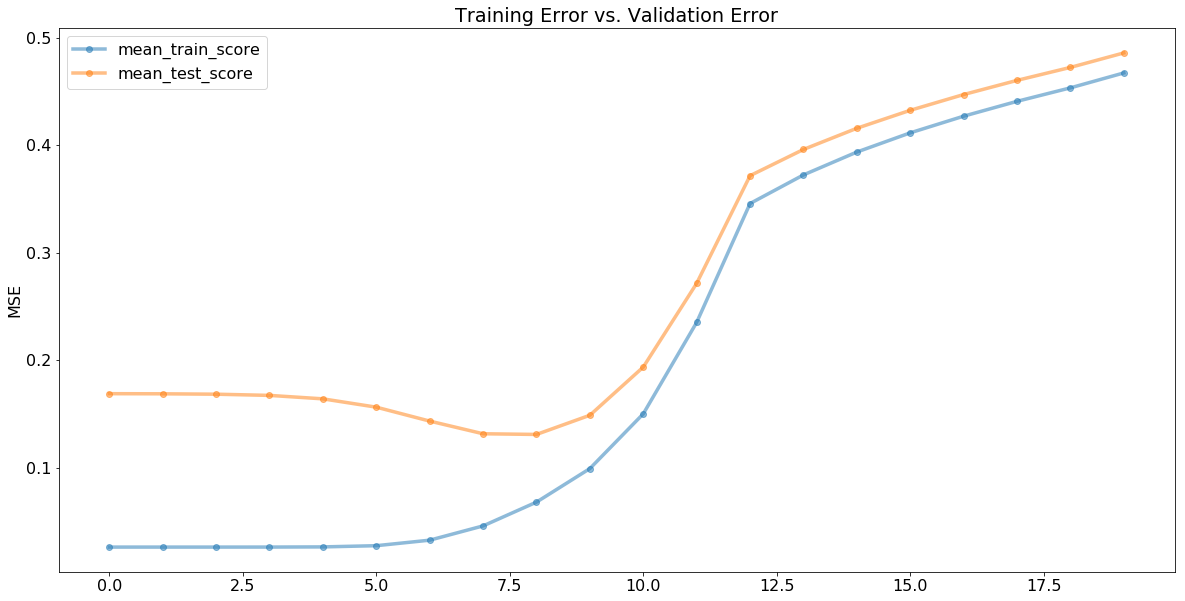

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(20,10))
plt.rcParams['font.size'] = 16
# plt.plot(lambdas)
plt.plot(training_error_mse, linewidth=3.5, alpha = 0.5, marker='o')
plt.plot(test_error_mse, linewidth=3.5, alpha = 0.5,  marker='o')
plt.title('Training Error vs. Validation Error')
plt.ylabel('MSE')
plt.legend()
# plt.savefig('ridge_training_validation_mse.png')

2. Now we want to visualize the prediction functions. On the same axes, plot the following: the training data, the target function, an unregularized least squares fit (still using the featurized data), and the prediction function chosen in the previous problem. Next, along the lines of the bar charts produced by the code in compare_parameter_vectors, visualize the coefficients for each of the prediction functions plotted, including the target function. Describe the patterns, including the scale of the coefficients, as well as which coefficients have the most weight.

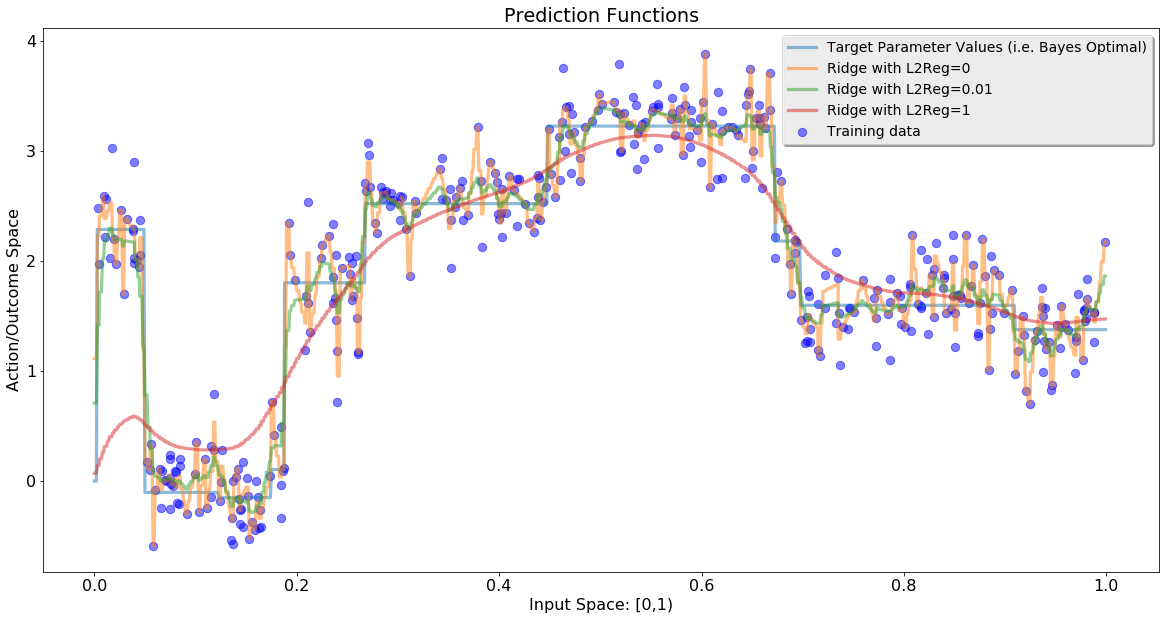

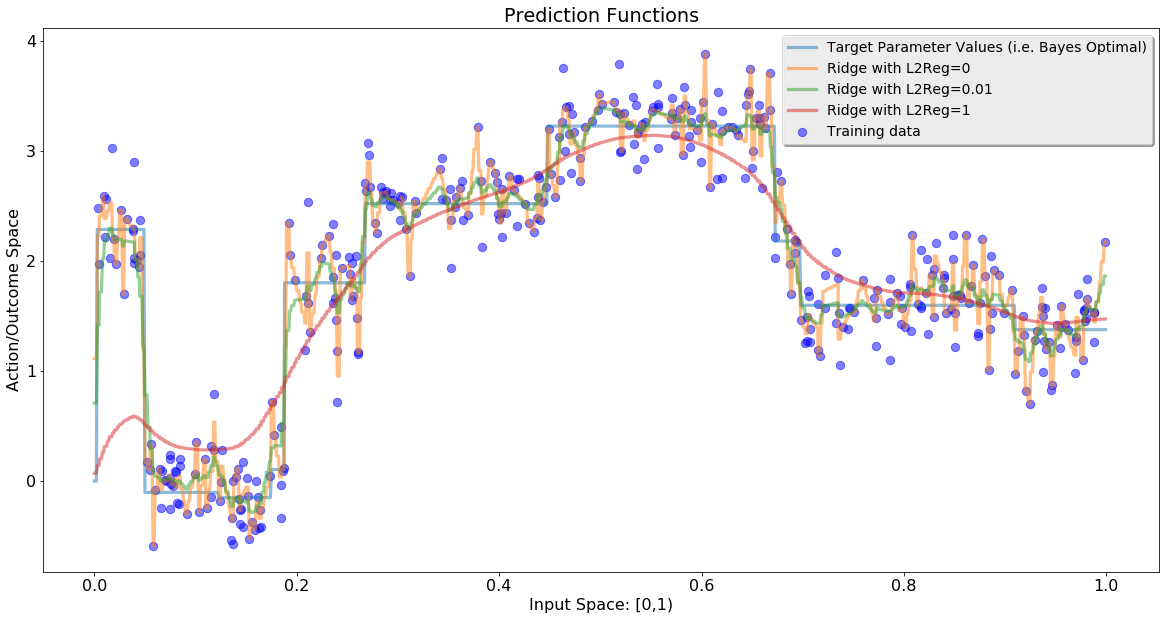

In [16]:
pred_fns = []
x = np.sort(np.concatenate([np.arange(0,1,.001), x_train]))
name = "Target Parameter Values (i.e. Bayes Optimal)"
pred_fns.append({"name":name, "coefs":coefs_true, "preds": target_fn(x) })

grid = do_grid_search_ridge(x_train_featurized, y_train, x_val_featurized, y_val)[0]
l2regs = [0, grid.best_params_['l2reg'], 1]
X = featurize(x)

for l2reg in l2regs:
    ridge_regression_estimator = RidgeRegression(l2reg=l2reg)
    ridge_regression_estimator.fit(x_train_featurized, y_train)
    name = "Ridge with L2Reg="+str(l2reg)
    pred_fns.append({"name":name,
                         "coefs":ridge_regression_estimator.w_,
                         "preds": ridge_regression_estimator.predict(X) })

plot_prediction_functions(x, pred_fns, x_train, y_train, legend_loc="best")


3. For the chosen λ, examine the model coefficients. For ridge regression, we don’t expect any parameters to be exactly 0. However, let’s investigate whether we can predict the sparsity pattern of the true parameters (i.e. which parameters are 0 and which are nonzero) by thresholding the parameter estimates we get from ridge regression. We’ll predict that wi = 0 if |wˆi| < ε and wi ̸= 0 otherwise. Give the confusion matrix for ε = 10−6, 10−3, 10−1, and any other thresholds you would like to try.

In [17]:
grid.best_params_ ##chosen lambda_reg

{'l2reg': 0.01}

In [18]:
ridge_best = RidgeRegression(l2reg=grid.best_params_['l2reg'])

In [19]:
ridge_best.fit(x_train_featurized, y_train)

RidgeRegression(l2reg=0.01)

In [20]:
pred_fns[0].keys()

dict_keys(['name', 'coefs', 'preds'])

In [21]:
for i in range(len(pred_fns)):
    print (pred_fns[i]['name'])
    print (pred_fns[i]['coefs'])

Target Parameter Values (i.e. Bayes Optimal)
[ 0.          2.28873293  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.         -2.39226322  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.04673114  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.25492853  0.
  0.          0.          0.          1.69902307  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.     

In [22]:
lambda_best_coefs = pred_fns[2]['coefs']
# lambda_best_coefs

In [23]:
epsilons = [1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.1]

In [24]:
import pandas as pd

epsilon_sparse = {}

for epsilon in epsilons: 
    epsilon_sparse[epsilon] = np.array(pd.Series(lambda_best_coefs).apply(lambda x: int(np.absolute(x) > epsilon)))
    

In [25]:
epsilon_sparse

{1e-06: array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1,

In [26]:
actual_sparse = {}

for key in epsilon_sparse.keys():
    actual_sparse[key] = epsilon_sparse[key]*lambda_best_coefs

actual_sparse

{1e-06: array([ 7.08737655e-01,  7.08737655e-01,  3.02764799e-01,  3.02764799e-01,
         1.60975663e-01,  5.78042850e-02,  5.78042854e-02, -5.88179412e-02,
        -4.97945494e-02,  3.89087836e-03,  3.89087179e-03, -6.19651957e-02,
         4.71388269e-02, -3.58801110e-03, -3.58801162e-03, -3.58801110e-03,
        -1.58433795e-01, -1.57268175e-01, -1.79113507e-01, -4.47719989e-01,
        -4.47719988e-01, -2.94948831e-01, -1.98151607e-01, -2.08637326e-01,
        -4.03506734e-02, -9.95120202e-03, -3.02646076e-02,  7.73347353e-03,
         7.46237826e-03,  1.12826318e-02, -1.58882439e-02, -6.31123428e-03,
        -1.46992662e-02,  9.56253731e-03, -2.35112606e-02, -2.35112606e-02,
        -2.35112589e-02,  3.31737957e-02,  3.31738000e-02,  3.31738000e-02,
         2.48079934e-02, -4.94078205e-02,  2.16497669e-02,  2.16497669e-02,
        -1.55380710e-02,  5.37083672e-02,  5.37083672e-02,  7.92391301e-02,
        -7.99549399e-02, -7.99549399e-02, -1.92202463e-02, -6.71755851e-02,
     

In [27]:
from sklearn.metrics import confusion_matrix

In [28]:
y_trues = {}
y_preds = {}
conf_ms = {}

for epsilon in epsilons: 
    y_trues[epsilon] = np.array(pd.Series(lambda_best_coefs).apply(lambda x: int(x > 0)))
    y_preds[epsilon] = np.array(pd.Series(actual_sparse[epsilon]).apply(lambda x: int(x > 0)))
#     conf_matrix = confusion_matrix(lambda_best_coefs, actual_sparse[epsilon])
    conf_ms[epsilon] = confusion_matrix(y_trues[epsilon], y_preds[epsilon])
#     plt.imshow(conf_ms[epsilon])
    print ('epsilon = ' + str(epsilon) + '\n')
    print (str(conf_ms[epsilon]) + '\n')
    

epsilon = 1e-06

[[202   0]
 [  0 198]]

epsilon = 1e-05

[[202   0]
 [  0 198]]

epsilon = 0.0001

[[202   0]
 [  0 198]]

epsilon = 0.001

[[202   0]
 [  3 195]]

epsilon = 0.01

[[202   0]
 [ 39 159]]

epsilon = 0.1

[[202   0]
 [180  18]]



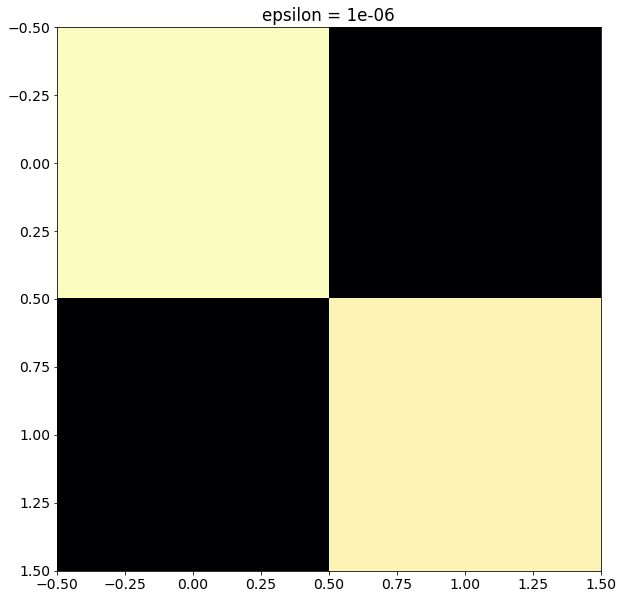

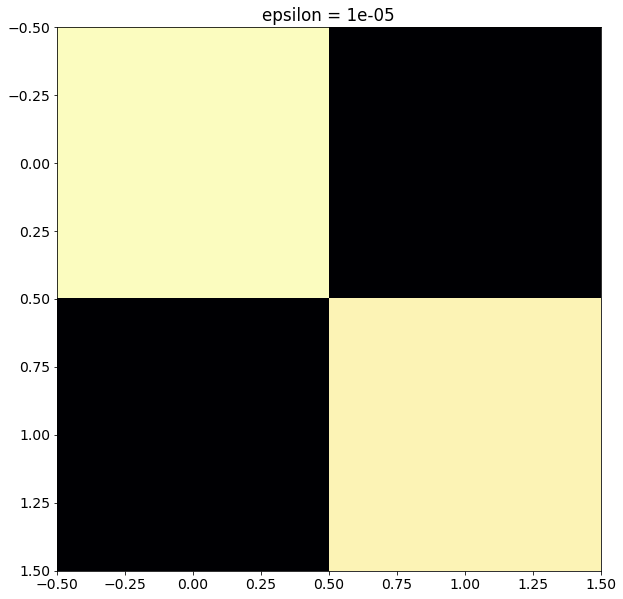

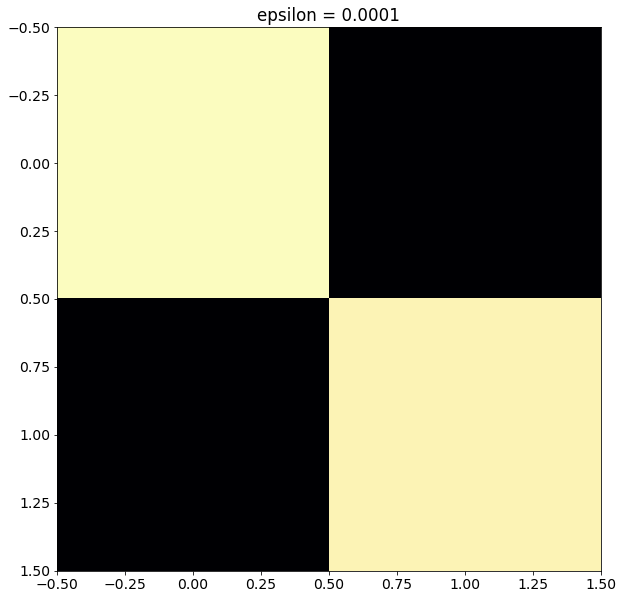

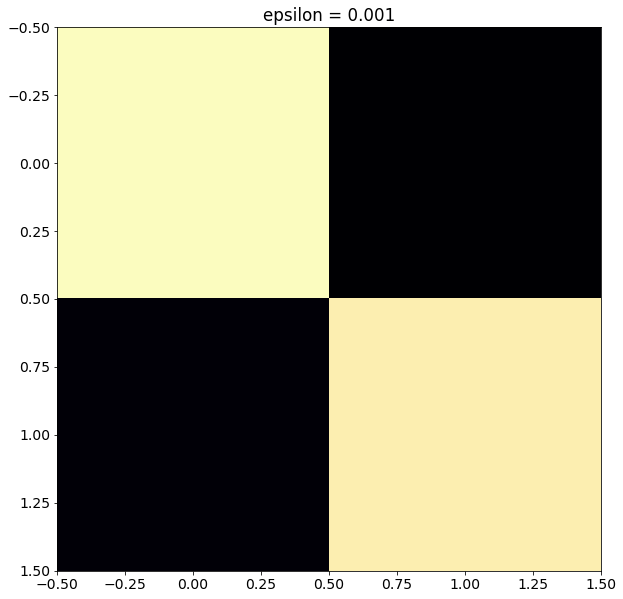

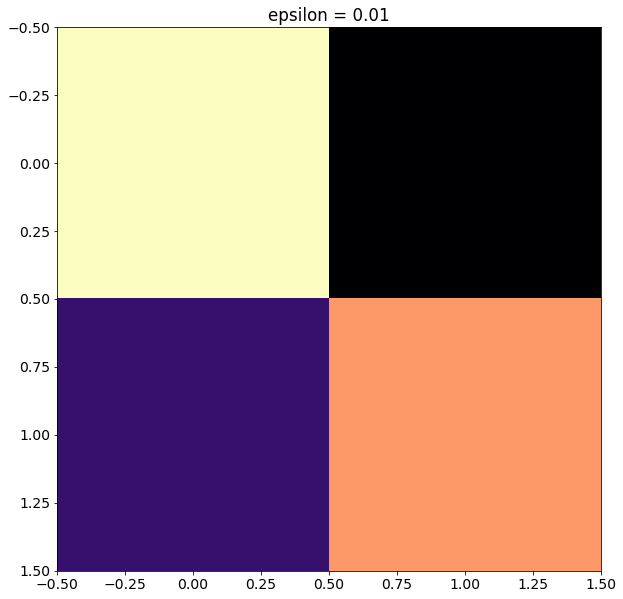

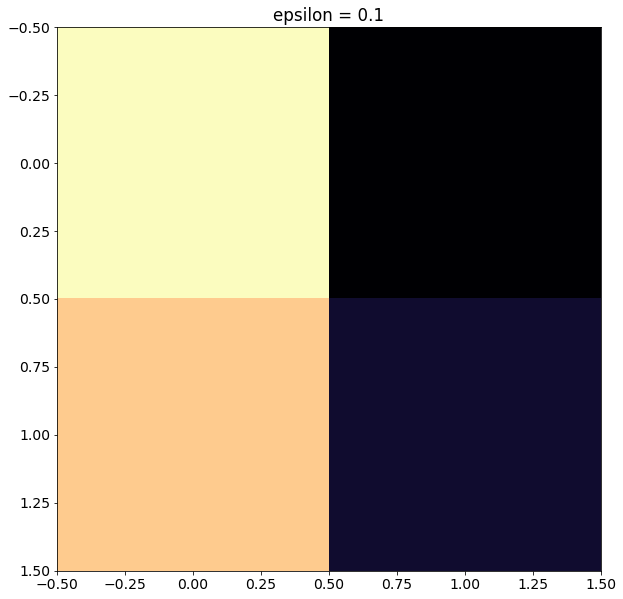

In [29]:
## bunlari anlamadim, farkli thresholdlarla coklu matrix yapma
## secenegimiz var mi?? 

for epsilon in epsilons:
    plt.figure(figsize = (20,10))
    plt.imshow(conf_ms[epsilon], cmap='magma')
    plt.title('epsilon = ' + str(epsilon))

### 3 - COORDINATE DESCENT FOR LASSO

1. The algorithm as described above is not ready for a large dataset (at least if it has being im- plemented in Python) because of the implied loop in the summation signs for the expressions for aj and cj. Give an expression for computing aj and cj using matrix and vector operations, without explicit loops. This is called “vectorization” and can lead to dramatic speedup when implemented in languages such as Python, Matlab, and R. Write your expressions using X, w, y = (y1, . . . , yn)T (the column vector of responses), X·j (the jth column of X, represented as a column matrix), and wj (the jth coordinate of w – a scalar).


In [30]:
A = np.array([[2, 3, 4], [5, 6, 7]])
B = np.dot(A, np.transpose(A))
2*np.dot(np.transpose(A[:, 0]), A[:, 0])

58

__a_j__ = (2*np.dot(np.transpose(X[:, i]), X[:, i]))

In [32]:
def compute_regularized_square_loss(X, y, theta, lambda_reg):
    """
    Given a set of X, y, theta, compute the square loss for predicting y with X*theta

    Args:
        X - the feature vector, 2D numpy array of size (num_instances, num_features)
        y - the label vector, 1D numpy array of size (num_instances)
        theta - the parameter vector, 1D array of size (num_features)

    Returns:
        loss - the square loss, scalar
    """
    loss = 0 #initialize the square_loss ### np.sum(theta oldugundan emin miyiz)
    loss = np.sum(np.square(np.dot(X, theta) - y)) + lambda_reg*np.sum(np.absolute(theta)) 
    
    return loss

In [33]:
def soft_thresholding(p, r):
    if p > r:
        return p-r
    elif np.absolute(p) <= r:
        return 0
    elif p < (-1*r):
        return p+r

In [45]:
def shooting(X, y, method='randomized', theta_init='zeros', max_iter=1000, conv_threshold=1e-8):
    
    
    num_instances, num_features = X.shape[0], X.shape[1]
    theta_hist = np.zeros((max_iter, num_features, num_features))  #Initialize theta_hist
    loss_hist = np.zeros((max_iter, num_features, num_features))#Initialize loss_hist
    lambda_reg = 2*np.max(np.dot(np.transpose(X), y))
    
    if theta_init == 'zeros':
        
        theta = np.zeros(num_features) 
        a = np.zeros(num_features)
        c = np.zeros(num_features)
        m = np.zeros(num_features)
        delta = np.zeros(num_features)
        
        if method == 'randomized':
            i = 0
            j = 0
            
            while i in range(max_iter-1):
                ## bunlarin iceride olmasi mantikli, her iterasyona baslamadan initialize ettik
                theta = theta
                loss = compute_regularized_square_loss(X, y, theta, lambda_reg)
                loss_hist[i,j][j] = loss
                print ('loss = ' + str(loss))
                
                js = []  

                while len(js) < len(theta):

                    j = np.random.choice(range(len(theta))) ## ise yaramazsa bir indent ileri at
                    js.append(j)
                    
                    print ('j =' + str(j))
                    a[j] = 2*(np.dot(np.transpose(X[:,j]), X[:,j]))
                    
                    
                    if a[j] == 0:
                        theta[j] = 0
                    else:
                        a[j] = a[j]
                        c[j] = 2*((np.dot(X[:,j], y)) -(np.dot(np.dot(X, theta), X[:,j])) + (np.dot(np.dot(theta[j], X[:,j]), X[:,j])))
                        print ('c = ' + str(c[j]))
                        print ('a = ' + str(a[j]))

                        m[j] = c[j]/a[j]
                        print ('m = ' + str(m[j]))

                        delta[j] = (lambda_reg/a[j])
                        print ('delta = ' + str(delta[j]))

                        theta[j] = soft_thresholding(m[j], delta[j]) 
                        theta_hist[i][j] = theta
                        loss = compute_regularized_square_loss(X, y, theta, lambda_reg)
                        loss_hist[i,j][j] = loss ## bundan emin degiliz
                        print ('theta_j = '+ str(theta[j]))
                        print ('loss_hist = ' + str(loss_hist))
                        
                        
                            
##                    j = np.random.choice(range(len(theta))) ## ise yaramazsa bir indent ileri at
##                    js.append(j)
                    
                
#                     print (js)
                    
                    print ('theta_hist = '+ str(theta_hist))
                    loss = compute_regularized_square_loss(X, y, theta, lambda_reg)
                    loss_hist[i,j][j] = loss ## bundan emin degiliz
                    print ('loss = '+ str(loss))
#                     print ('loss_hist = '+ str(loss_hist))
                    
#                 while len(js) > len(theta):
#                     pass
                    
                i = i + 1    
            
                while i not in range(max_iter-1):
                    break
                    return theta_hist, loss_hist
#             while loss_hist[i,j] - loss_hist[i-1,j] > conv_threshold:     
#                 i = i + 1 ## ise yaramazsa bir indent geri al
#                 print ('i = ' + str(i))
#             while loss_hist[i,j] - loss_hist[i-1,j] > conv_threshold:     
#                 break
                        
        elif method == 'cyclic':
            
            i = 0
            
            while i in range(max_iter-1):
                ### we do not randomly select the index, we just cycle through the features

                for j in range(len(theta)):
                    
                    loss = compute_regularized_square_loss(X, y, theta, lambda_reg)
                    loss_hist[i,j][j] = loss ## bundan emin degiliz
                    a[j] = 2*(np.dot(np.transpose(X[:,j]), X[:,j]))
                    
                    if a[j] == 0:
                        theta[j] = 0
                    else:
                        a[j] = a[j]
                        c[j] = 2*((np.dot(X[:,j], y)) -(np.dot(np.dot(X, theta), X[:,j])) + (np.dot(np.dot(theta[j], X[:,j]), X[:,j])))
                        m[j] = c[j]/a[j]
                        delta[j] = (lambda_reg/a[j])

                        theta[j] = soft_thresholding(m[j], delta[j]) 
                        theta_hist[i][j] = theta
                        loss = compute_regularized_square_loss(X, y, theta, lambda_reg)
                        loss_hist[i,j][j] = loss 
                        print ('theta_j = '+ str(theta[j]))
                        print ('loss_hist = ' + str(loss_hist))
                        print ('theta_hist = '+ str(theta_hist))

                        while loss_hist[i, j][-1] < 5:
                            if loss_hist[i, j][-1] - loss_hist[i-1, j][-1] <= conv_threshold:
                                return theta_hist, loss_hist  #### bu conditioni degistirmen lazim 
                            else:
                                continue

                i = i + 1
                while i not in range(max_iter-1):
                    break
                    return theta_hist, loss_hist



#     elif theta_init == 'warm_start':
                
#                 ## digerinin best cozumu ile basliyoruz, bastan 0la degil


#             if method == 'randomized':

#                     np.random.shuffle(theta)
                    
#                     for j in range(len(theta)):
#                         a[j] = 2*(np.dot(np.transpose(X[:,j]), X[:,j]))
#                         ## loss'u tekrar hesaplamadan theta'yi update ediyor olduguna emin ol 
#                         loss = compute_regularized_square_loss(X, y, theta, lambda_reg)
#                         loss_hist[i] = loss

#             elif method == 'cyclic':


#                     for j in range(len(theta)):
#                         a[j] = 2*(np.dot(np.transpose(X[:,j]), X[:,j]))
#                         ## loss'u tekrar hesaplamadan theta'yi update ediyor olduguna emin ol 
#                         loss = compute_regularized_square_loss(X, y, theta, lambda_reg)
#                         loss_hist[i] = loss

                    
# #             while loss_hist[i][-1] - loss_hist[i - 1][-1] > conv_threshold:
# #     i = i + 1 ### bu dogru yerde mi yoksa convergence threshold'un altinda mi olmali bilmiyorum
#         ## her loopun sonuna koyabiliriz
#     return theta_hist, loss_hist
            


In [46]:
shooting(x_train_featurized, y_train, method='randomized', theta_init='zeros', max_iter=3, conv_threshold=1e-8)



loss = 1923.8996073535727
j =75
c = 1426.6264016523216
a = 628.0
m = 2.27169809180306
delta = 2.4148729678417684
theta_j = 0.0
loss_hist = [[[1923.89960735    0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  ...
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]]

 [[   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  ...
  [   0.            0.            0.         ...    0.
      0. 

j =95
c = 1372.9622582039467
a = 600.0
m = 2.288270430339911
delta = 2.5275670396743846
theta_j = 0.0
loss_hist = [[[1923.89960735    0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  ...
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]]

 [[   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  ...
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  

theta_j = 0.0
loss_hist = [[[1923.89960735    0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  ...
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]]

 [[   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  ...
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [

  [0. 0. 0. ... 0. 0. 0.]]]
loss = 1923.8996073535727
j =271
c = 407.13107017851564
a = 258.0
m = 1.5780274037926962
delta = 5.878062882963684
theta_j = 0.0
loss_hist = [[[1923.89960735    0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  ...
  [   0.            0.            0.         ... 1923.89960735
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]]

 [[   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  ...
  [   0.            0.    

c = 1423.7467903468118
a = 668.0
m = 2.1313574705790597
delta = 2.2702697961147167
theta_j = 0.0
loss_hist = [[[1923.89960735    0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  ...
  [   0.            0.            0.         ... 1923.89960735
      0.            0.        ]
  [   0.            0.            0.         ...    0.
   1923.89960735    0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]]

 [[   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  ...
  [   0.            0.            0.         ...    0.
      0.            0.        ]

j =261
c = 480.371849949276
a = 282.0
m = 1.7034462764158724
delta = 5.377802212073158
theta_j = 0.0
loss_hist = [[[1923.89960735    0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  ...
  [   0.            0.            0.         ... 1923.89960735
      0.            0.        ]
  [   0.            0.            0.         ...    0.
   1923.89960735    0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]]

 [[   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  ...
  [   0.            0.            0.         ...    0.
      0.            0.     

a = 74.0
m = 1.3722596778561176
delta = 20.493786808170682
theta_j = 0.0
loss_hist = [[[1923.89960735    0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  ...
  [   0.            0.            0.         ... 1923.89960735
      0.            0.        ]
  [   0.            0.            0.         ...    0.
   1923.89960735    0.        ]
  [   0.            0.            0.         ...    0.
      0.         1923.89960735]]

 [[   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  ...
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0. 

a = 228.0
m = 1.5515358980440224
delta = 6.651492209669432
theta_j = 0.0
loss_hist = [[[1923.89960735    0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  ...
  [   0.            0.            0.         ... 1923.89960735
      0.            0.        ]
  [   0.            0.            0.         ...    0.
   1923.89960735    0.        ]
  [   0.            0.            0.         ...    0.
      0.         1923.89960735]]

 [[   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  ...
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0. 

  [0. 0. 0. ... 0. 0. 0.]]]
loss = 1923.8996073535727
j =356
c = 119.14504512813761
a = 86.0
m = 1.3854075014899723
delta = 17.634188648891055
theta_j = 0.0
loss_hist = [[[1923.89960735    0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  ...
  [   0.            0.            0.         ... 1923.89960735
      0.            0.        ]
  [   0.            0.            0.         ...    0.
   1923.89960735    0.        ]
  [   0.            0.            0.         ...    0.
      0.         1923.89960735]]

 [[   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  ...
  [   0.            0.    

theta_j = 0.0
loss_hist = [[[1923.89960735    0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  ...
  [   0.            0.            0.         ... 1923.89960735
      0.            0.        ]
  [   0.            0.            0.         ...    0.
   1923.89960735    0.        ]
  [   0.            0.            0.         ...    0.
      0.         1923.89960735]]

 [[   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  ...
  [   0.            0.            0.         ...    0.
      0.            0.        ]
  [   0.            0.            0.         ...    0.
      0.            0.     